##
Originally, my goal was to predict "gentrification" labels from census data.

This goal ultimately led to a few problems.

First, the "labels" I was using turned out to be compound indices, produced by combining several variables I had access to. While re-learning the compound index function isn't intrinsically bad, it doesn't really answer any research questions.

So, in response, we removed all of those features that went into the original, compound index ("cheaters"). Our goal here was to learn which features correlated with our compound index.


Let's see how we did:

In [1]:
# import jtplot module in notebook
from jupyterthemes import jtplot
jtplot.style(theme='grade3')
%pylab inline
%load_ext autoreload
%autoreload 2
import itertools
from typing import Tuple, Dict, List, Callable
# if you get any complaints about missing dependencies, 
# comment out the line before the dependency to install it.
# (just remember to comment that line out again after installation)
# !pip3 install pandas
import pandas as pd
# !pip3 install funcy
from funcy import *
# !pip3 install numpy
import numpy as np
# Install instructions here: 
#   https://xgboost.readthedocs.io/en/latest/python/python_intro.html
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
# !pip3 install sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# !pip3 install scipy
from scipy.stats import ttest_ind
import utils

Populating the interactive namespace from numpy and matplotlib


In [2]:
udp_90_00 = pd.read_csv('data/udp9000.csv')
udp_00_13 = pd.read_csv('data/udp0013.csv')
udp_00_15 = pd.read_csv('data/udp0015.csv')
labels    = pd.read_csv('data/labels.csv')

# Tests

In [3]:
# Test `utils.align()` 
def test_align (df):
    # `align` will raise if there's an alignment issue
    f, l = utils.align(df, labels)
    return f.shape[0] == l.shape[0]
assert test_align(udp_90_00)
assert test_align(udp_00_13)
assert test_align(udp_00_15)

In [4]:
# Test `utils.X_y`
X, y = utils.X_y(udp_90_00, labels, 'disp_type_num',
           mapper=lambda x: 1 if x == 4 else 0
          )

# Dimensions are right
assert X.shape == (1580, 284)
assert y.shape == (1580,)
# Labels has 0 and 1 values
assert np.any(y == 1)
assert np.any(y == 0)
assert not np.any(y == 2)
assert not np.any(y == 3)
assert not np.any(y == 4)

In [5]:
assert utils.prior_probability(y) == 0.10126582278481013

# Classification

In [6]:
def plot_confusion_matrix(
    cm: np.ndarray,
    classes: List[int],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
    ) -> None:
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[453  48]
 [  8  13]]


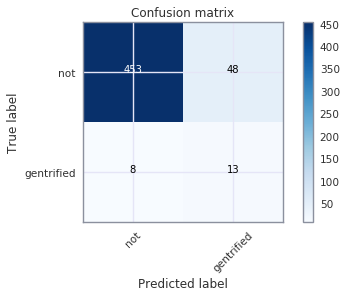

In [8]:
# method to cv + validate
X, y = utils.X_y(udp_00_15, labels, 'disp_type_num',
           mapper=lambda x: 1 if x == 4 else 0
          )

X_train, X_test, y_train, y_test =\
train_test_split(X,
                 y,
                 test_size=0.33,  # Test size should be smaller
                 random_state=0) # This "random" method will always produce
                                 # the same results, if we keep the random_state
                                 # the same. (If this is mysterious, look up PRNGs.)
        

alg, res = utils.xgb_cv(
    X_train,
    y_train,
    base_score=utils.prior_probability(y_train)
)

# alg.score(X_test, y_test)
ypred = alg.predict(X_test)
mtrx = confusion_matrix(ypred, y_test)
plot_confusion_matrix(mtrx, ['not', 'gentrified'])

## Conclusion

Unfortunately, this too does not yield the outcome we expected. When properly splitting into training and validation sets, cross-validating on training and testing on validation, we find false positives - predicted gentrified, but not acutally gentrified.

We could, of course, train on all of the data in our dataset, without witholding anything. But, what would this really tell us about our underlying data? After all, our classifier could simply memorize those features in order to predict labels!


## Reflecting on the original false-positive problem

As a side-note, these results imply that the original false-positive problem in inter-period classification was almost certainly one of overfitting. The original regression model was "trained" on all of the source data. While this almost certainly produced a regression with a good fit, how well did that model generalize?

We can't know the answer to that question unless we split the data into train and tests sets, "cross-validating" our performance by training and testing a model on different splits of the data. Without doing this, our model will likely overfit to particularities of the individual period - resulting in false-positives in your original model, and false-negatives in my XGBoost model.

## Future work

There are a few ways we can go from here. The first, and simplest, is to produce labels that are not derived from the data we are interested in classifying. We could do this a number of ways: One might be to find some other way of producing "gentrification" and "exclusion" labels. Asking locals to label maps might be one way of crowd-sourcing our problem using local knowledge. Another (admittedly more neoliberal) idea might be to use rent prices as a proxy for gentrification, scraping Craigslist or some similar site. Once these labels are generated, we can return to our census data and use these as features to predict our labels.

Another option might be to use these compound indices as labels for a new classification problem. We might use as source data street view images, 311 calls, etc. The key in selecting such a dataset must be size. Our current dataset is small (under 10,000 points). A large dataset will allow us to build more robust models, which should generalize better across years.
